In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('../..')
import torch
import os

In [2]:
from mps.utils import train_from_dataset, MeasurementDataset, make_exp_schedule
from mps.utils import train_from_filepath
from mps.qtools import pauli_exp
from mps.models import MPS

Loaded libmkl_rt.so for dgesvd


In [3]:
trlosses = np.load("data/trlosses.npy")
vallosses = np.load("data/vallosses.npy")
params = np.load("data/validated_params.npy").item()
with open("data/metadata.json") as f:
    val_metadata=json.load(f)

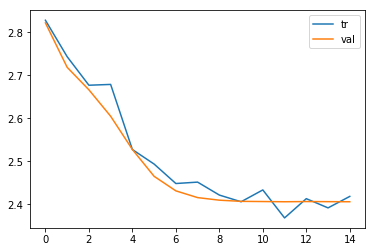

In [4]:
fig, ax = plt.subplots()
plt.plot(trlosses, label="tr")
plt.plot(vallosses, label="val")
plt.legend()

Prepare and write a json file for the full training script

In [5]:
training_settings = val_metadata.copy()

In [6]:
for p in ['lr_scale', 'lr_timescale', 's2_scale', 's2_timescale']:
    training_settings[p] = params[p]

In [7]:
L=4
fname_angles = "../../datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "../../datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
fname_state = "../../datasets/mps_sampled/ghz_plus_L=%d_state"%L
output_dir = "./data"
Nsamp=20000


In [8]:
training_settings['mps_path'] = fname_state

Update with the actual number of epochs used

In [9]:
epochs = int(1.0*len(trlosses))
training_settings['epochs'] = epochs

In [10]:
fname_training_settings = os.path.join(output_dir, 'training_settings.json')

In [11]:
with open(os.path.join(output_dir, 'training_settings.json'), 'w') as f:
    json.dump(training_settings, f)

In [12]:
model, logdict, meta = train_from_filepath(fname_samples, fname_angles,
                                           fname_training_settings, 
                                           N=Nsamp,
                                           numpy_seed=0,
                                       use_cache=True, record_eigs=False,record_s2=True,verbose=True,
                                       compute_overlaps=True)

Successfully loaded 20000 settings, samples for system of size L=4
Loading training settings from ./data/training_settings.json
Loaded the following settings:
lr_scale = 1.165400e-02
lr_timescale = 9.058899e+01
s2_scale = 3.107953e-06
s2_timescale = 7.610777e+01
epochs = 1.500000e+01
cutoff = 1.000000e-05
max_sv = 1.000000e+01
batch_size = 1.024000e+03
loading ground truth MPS from  ../../datasets/mps_sampled/ghz_plus_L=4_state


ModuleNotFoundError: No module named 'models'

In [ ]:
fidelity_mps = logdict['fidelity_mps']
fidelity_qutip = logdict['fidelity_qutip']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']
val_loss = logdict['val_loss']
overlap = logdict['overlap']

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.plot(val_loss, label='val set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


In [ ]:
fig, ax = plt.subplots()
plt.plot(range(epochs), fidelity_mps**2, label='mps overlap')

c = overlap['converged']
plt.errorbar(np.arange(epochs)[c], overlap['mean'][c], yerr=overlap['err'][c], marker='o', linestyle='none', 
            label="random unitary estimate")
plt.legend()
plt.xlabel('epoch')
plt.title("Overlap during training")